In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

2025-08-31 15:33:00.197202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756654380.219403    5257 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756654380.225995    5257 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = "/kaggle/input/movie-lens-small-latest-dataset" 
print(os.listdir(data_path))

['movies.csv', 'ratings.csv', 'README.txt', 'tags.csv', 'links.csv']


In [3]:
movies = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/movies.csv")
ratings = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/ratings.csv")

In [4]:
# Reindexing IDs to have consecutive indices
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

# Creating mappings
user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}
idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}

# Applying the mappings
ratings['user_idx'] = ratings['userId'].map(user_to_idx)
ratings['movie_idx'] = ratings['movieId'].map(movie_to_idx)

n_users = len(user_ids)
n_movies = len(movie_ids)

print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")
print(f"Matrix sparsity: {(1 - len(ratings) / (n_users * n_movies)) * 100:.2f}%")

Number of users: 610
Number of movies: 9724
Matrix sparsity: 98.30%


In [5]:
def create_user_item_matrix(ratings_df, n_users, n_movies):
    """Create the user-item matrix"""
    matrix = np.zeros((n_users, n_movies))
    for _, row in ratings_df.iterrows():
        matrix[int(row['user_idx']), int(row['movie_idx'])] = row['rating']
    return matrix

user_item_matrix = create_user_item_matrix(ratings, n_users, n_movies)
print(f"Shape of the user-item matrix: {user_item_matrix.shape}")

# Binary matrix to indicate observed ratings
observed_matrix = (user_item_matrix > 0).astype(float)
print(f"Number of observed ratings: {observed_matrix.sum()}")

Shape of the user-item matrix: (610, 9724)
Number of observed ratings: 100836.0


In [6]:
train_users, temp_users = train_test_split(
    range(n_users), test_size=0.4, random_state=42
)
val_users, test_users = train_test_split(
    temp_users, test_size=0.5, random_state=42
)

print(f"Train users: {len(train_users)}")
print(f"Validation users: {len(val_users)}")
print(f"Test users: {len(test_users)}")

# Creating matrices for each split
train_matrix = user_item_matrix[train_users]
val_matrix = user_item_matrix[val_users]
test_matrix = user_item_matrix[test_users]

train_observed = observed_matrix[train_users]
val_observed = observed_matrix[val_users]
test_observed = observed_matrix[test_users]

Train users: 366
Validation users: 122
Test users: 122


In [7]:
class UAutoRec(keras.Model):
    def __init__(self, n_items, hidden_dim=500, dropout_rate=0.05):
        super(UAutoRec, self).__init__()
        self.n_items = n_items
        self.hidden_dim = hidden_dim
        
        # Encoder
        self.encoder = keras.Sequential([
            layers.Dense(hidden_dim, activation='sigmoid', name='encoder'),
            layers.Dropout(dropout_rate)
        ])
        
        # Decoder
        self.decoder = keras.Sequential([
            layers.Dense(n_items, activation='linear', name='decoder')
        ])
        
    def call(self, inputs, training=None):
        # inputs shape: (batch_size, n_items)
        encoded = self.encoder(inputs, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded
    
    def get_config(self):
        return {
            'n_items': self.n_items,
            'hidden_dim': self.hidden_dim
        }

In [8]:
def masked_mse_loss(y_true, y_pred, mask):
    """
    Compute the MSE loss only on observed ratings
    """
    # Mask predictions to consider only observed ratings
    masked_pred = y_pred * mask
    masked_true = y_true * mask
    
    # Compute the difference
    diff = masked_true - masked_pred
    squared_diff = tf.square(diff)
    
    # Sum only over observed elements
    loss = tf.reduce_sum(squared_diff) / tf.reduce_sum(mask)
    
    return loss

class MaskedMSE(keras.losses.Loss):
    def __init__(self, name="masked_mse"):
        super().__init__(name=name)
    
    def call(self, y_true, y_pred):
        # y_true contains both ratings and the mask
        ratings = y_true[:, :n_movies]
        mask = y_true[:, n_movies:]
        
        return masked_mse_loss(ratings, y_pred, mask)


class MaskedRMSE(keras.metrics.Metric):
    def __init__(self, name="masked_rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_squared_error = self.add_weight(name="total_squared_error", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        ratings = y_true[:, :n_movies]
        mask = y_true[:, n_movies:]
        
        masked_pred = y_pred * mask
        masked_true = ratings * mask
        
        squared_diff = tf.square(masked_true - masked_pred)
        
        self.total_squared_error.assign_add(tf.reduce_sum(squared_diff))
        self.count.assign_add(tf.reduce_sum(mask))
    
    def result(self):
        return tf.sqrt(self.total_squared_error / self.count)
    
    def reset_state(self):
        self.total_squared_error.assign(0.)
        self.count.assign(0.)


In [9]:
X_train = train_matrix 
X_val = val_matrix       
X_test = test_matrix  

# Targets combine ratings and mask
y_train = np.concatenate([train_matrix, train_observed], axis=1)
y_val = np.concatenate([val_matrix, val_observed], axis=1)
y_test = np.concatenate([test_matrix, test_observed], axis=1)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"X_train contains ratings: {X_train.shape[1]} movies")
print(f"y_train contains ratings + mask: {y_train.shape[1]} features")


HIDDEN_DIM = 500
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.05
BATCH_SIZE = 128
EPOCHS = 100


model = UAutoRec(n_items=n_movies, hidden_dim=HIDDEN_DIM, dropout_rate=DROPOUT_RATE)

# Compilation
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=MaskedMSE(),
    metrics=[MaskedRMSE()]
)


input_shape = (n_movies,)
model.build(input_shape=(None, n_movies))


dummy_input = np.zeros((1, n_movies))
_ = model(dummy_input)

print(f"Input shape: {input_shape}")
print(f"Number of movies: {n_movies}")
print(f"Hidden dimension: {HIDDEN_DIM}")

model.summary()


# Callback to save the best model
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_u_autorec_model.weights.h5',
    monitor='val_masked_rmse',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Callback to reduce learning rate
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_masked_rmse',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Early stopping
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_masked_rmse',
    patience=10,
    mode='min',  # minimizing RMSE
    restore_best_weights=True,
    verbose=1
)

# Callback to log metrics
class MetricsLogger(keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_rmse = []
        self.val_rmse = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.train_rmse.append(logs.get('masked_rmse'))
        self.val_rmse.append(logs.get('val_masked_rmse'))
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Train RMSE: {logs.get('masked_rmse'):.4f}, "
                  f"Val RMSE: {logs.get('val_masked_rmse'):.4f}")

metrics_logger = MetricsLogger()

callbacks = [
    checkpoint_callback,
    reduce_lr_callback,
    early_stopping_callback,
    metrics_logger
]


Shape X_train: (366, 9724)
Shape y_train: (366, 19448)
X_train contains ratings: 9724 movies
y_train contains ratings + mask: 19448 features


I0000 00:00:1756654386.918170    5257 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756654386.918912    5257 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'u_auto_rec', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Input shape: (9724,)
Number of movies: 9724
Hidden dimension: 500


Model: "u_auto_rec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (1, 500)                    │       4,862,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (1, 9724)                   │       4,871,724 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,734,224 (37.13 MB)

 Trainable params: 9,734,224 (37.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1756654389.144725    5310 service.cc:148] XLA service 0x7d9eec008c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756654389.144797    5310 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756654389.144804    5310 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756654389.243248    5310 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 13.6949 - masked_rmse: 3.7007

I0000 00:00:1756654390.339595    5310 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 12.7784 - masked_rmse: 3.5641
Epoch 1: val_masked_rmse improved from inf to 2.77124, saving model to best_u_autorec_model.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 12.5612 - masked_rmse: 3.5342 - val_loss: 7.6798 - val_masked_rmse: 2.7712 - learning_rate: 0.0010
Epoch 2/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.0731 - masked_rmse: 2.8413
Epoch 2: val_masked_rmse improved from 2.77124 to 1.72746, saving model to best_u_autorec_model.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 6.7239 - masked_rmse: 2.5583 - val_loss: 2.9841 - val_masked_rmse: 1.7275 - learning_rate: 0.0010
Epoch 3/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.9027 - masked_rmse: 1.7037
Epoch 3: val_masked_rmse improved from 1.72746 to 1.30555, saving model to best_u_autorec_model.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 2.3463 - masked_rmse: 1.5126 - val_loss: 1.7044 - val_masked_rmse: 1.3055 - learning_rate: 0.0010

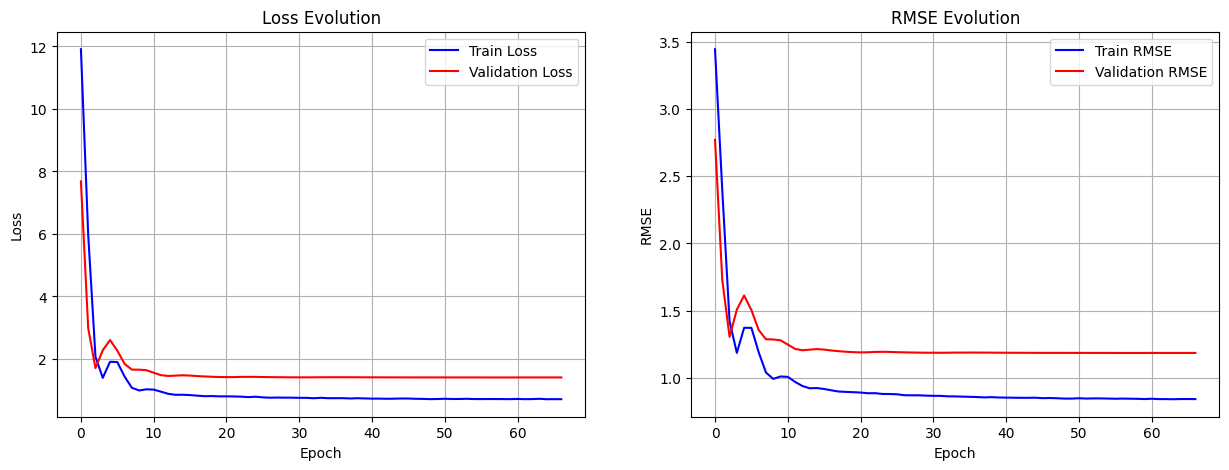

In [10]:
# Training 

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


# Training curves
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['masked_rmse'], label='Train RMSE', color='blue')
plt.plot(history.history['val_masked_rmse'], label='Validation RMSE', color='red')
plt.title('RMSE Evolution')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)


# Evaluation on the test set
print("Evaluation on the test set")

# Load the best weights
model.load_weights('best_u_autorec_model.weights.h5')

# Predictions on the test set
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

# Compute metrics on the test set
def calculate_metrics(true_ratings, predictions, mask):
    """Compute RMSE and MAE on observed ratings"""
    masked_true = true_ratings * mask
    masked_pred = predictions * mask
    
    # Extract only non-zero values
    observed_indices = mask > 0
    true_observed = masked_true[observed_indices]
    pred_observed = masked_pred[observed_indices]
    
    rmse = np.sqrt(mean_squared_error(true_observed, pred_observed))
    mae = mean_absolute_error(true_observed, pred_observed)
    
    return rmse, mae

test_rmse, test_mae = calculate_metrics(test_matrix, test_predictions, test_observed)

print(f"\nResults on the test set:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")